In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


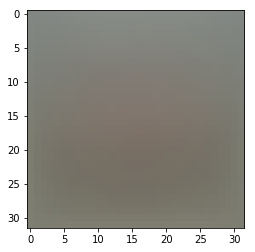

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.810745


In [7]:
X_dev.shape

(500, 3073)

In [8]:
W.shape

(3073, 10)

In [9]:
num_classes = W.shape[1]
num_train = X_dev.shape[0]
num_classes, num_train

(10, 500)

In [10]:
dW = np.zeros(W.shape)
dW.shape

(3073, 10)

In [52]:
scores = X_dev.dot(W)
slices = y_dev.reshape(y_dev.shape[0], 1)
true_scores = np.take_along_axis(scores, slices, axis=1)
margins = scores - true_scores + 1

In [53]:
margins.shape

(500, 10)

In [54]:
idx_positive_margins = np.greater(margins, 0).astype('int')
print(idx_positive_margins.shape)
idx_positive_margins

(500, 10)


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [57]:
idx_positive_margins.sum(axis=1)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4,  9, 10, 10, 10,  8, 10,
       10, 10, 10, 10, 10, 10,  9, 10, 10,  9, 10, 10,  8, 10,  8, 10, 10,
       10,  9,  9, 10,  9, 10, 10, 10,  8, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        9, 10, 10, 10, 10,  8, 10,  6, 10, 10, 10, 10, 10,  6, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10,  9,  8, 10, 10,  9, 10, 10, 10, 10,
       10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8, 10,
        7,  9,  7, 10, 10, 10,  8,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        9, 10, 10, 10, 10, 10, 10, 10, 10,  7, 10,  9,  9, 10, 10, 10,  7,
        3, 10, 10, 10, 10, 10, 10, 10, 10,  9, 10,  9,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,
       10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  7, 10, 10, 10, 10,
        7, 10, 10, 10,  8

In [48]:
idx_positive_margins[range(num_train), y_dev] -= idx_positive_margins.sum(axis=1)
print(idx_positive_margins.shape)
idx_positive_margins

(500, 10)


array([[ 1,  1,  1, ..., -9,  1,  1],
       [ 1,  1,  1, ...,  1, -9,  1],
       [-9,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1, -9, ...,  1,  1,  1],
       [ 1,  0,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -9,  1,  1]])

In [62]:
scores = X_dev.dot(W)
true_scores_position = y_dev.reshape(y_dev.shape[0], 1)
true_scores = np.take_along_axis(scores, true_scores_position, axis=1)
margins = np.maximum(0, scores - true_scores + 1)
margins_temp = np.copy(margins)
margins_temp[margins_temp > 0] = 1
print(margins_temp.shape)
margins_temp

(500, 10)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [63]:
np.take_along_axis(margins_temp, true_scores_position, axis=1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [69]:
aa = np.take_along_axis(margins_temp, true_scores_position, axis=1) - margins_temp.sum(axis=1)[:, np.newaxis]

In [70]:
np.put_along_axis(margins_temp, true_scores_position, aa, axis=1)
print(margins_temp.shape)
margins_temp

(500, 10)


array([[ 1.,  1.,  1., ..., -9.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -9.,  1.],
       [-9.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1., -9., ...,  1.,  1.,  1.],
       [ 1.,  0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -9.,  1.,  1.]])

In [37]:
margins.shape

(500, 10)

In [38]:
margins

array([[1.3791269 , 1.69552684, 1.27779678, ..., 1.        , 2.01782519,
        2.1840445 ],
       [0.79942536, 0.86426785, 0.83557678, ..., 0.91961226, 1.        ,
        0.41116875],
       [1.        , 1.09996838, 1.55825574, ..., 0.77131324, 1.45465675,
        1.29355117],
       ...,
       [2.10151533, 2.30225012, 1.        , ..., 1.29465829, 1.31813954,
        2.08828412],
       [0.80652818, 0.        , 0.22676431, ..., 0.60967589, 0.2149816 ,
        0.36562855],
       [1.72619304, 1.38722527, 1.04000111, ..., 1.        , 1.77263986,
        1.68199156]])

In [39]:
np.put_along_axis(margins, slices, -1, axis=1)
margins

array([[ 1.3791269 ,  1.69552684,  1.27779678, ..., -1.        ,
         2.01782519,  2.1840445 ],
       [ 0.79942536,  0.86426785,  0.83557678, ...,  0.91961226,
        -1.        ,  0.41116875],
       [-1.        ,  1.09996838,  1.55825574, ...,  0.77131324,
         1.45465675,  1.29355117],
       ...,
       [ 2.10151533,  2.30225012, -1.        , ...,  1.29465829,
         1.31813954,  2.08828412],
       [ 0.80652818,  0.        ,  0.22676431, ...,  0.60967589,
         0.2149816 ,  0.36562855],
       [ 1.72619304,  1.38722527,  1.04000111, ..., -1.        ,
         1.77263986,  1.68199156]])

In [23]:
margins[margins > 0] = 1
margins

array([[ 1.,  1.,  1., ..., -1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [-1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1.,  0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1.,  1.,  1.]])

In [29]:
margins[:,:, np.newaxis].shape

(500, 10, 1)

In [34]:
X_dev.transpose()[:,:, np.newaxis] * margins[:,:, np.newaxis]

ValueError: operands could not be broadcast together with shapes (3073,500,1) (500,10,1) 

In [14]:
margins.shape

(500, 10)

In [15]:
dW = np.ones(W.shape)
dW.shape

(3073, 10)

In [16]:
dW

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [17]:
margins.shape

(500, 10)

In [18]:
X_dev.shape

(500, 3073)

In [19]:
X_dev

array([[  99.35810204,   71.01826531,   32.52608163, ...,   24.13804082,
          19.60042857,    1.        ],
       [  -1.64189796,   27.01826531,   93.52608163, ...,  -57.86195918,
         -19.39957143,    1.        ],
       [ -59.64189796,   -1.98173469,   60.52608163, ...,   41.13804082,
          43.60042857,    1.        ],
       ...,
       [-126.64189796,  -81.98173469,  -38.47391837, ...,  -63.86195918,
          -3.39957143,    1.        ],
       [  16.35810204,  -60.98173469, -128.47391837, ...,  -77.86195918,
        -104.39957143,    1.        ],
       [  53.35810204,   34.01826531,   34.52608163, ...,   42.13804082,
          56.60042857,    1.        ]])

In [20]:
X_dev.transpose().shape

(3073, 500)

In [22]:
X_dev.transpose()

array([[  99.35810204,   -1.64189796,  -59.64189796, ..., -126.64189796,
          16.35810204,   53.35810204],
       [  71.01826531,   27.01826531,   -1.98173469, ...,  -81.98173469,
         -60.98173469,   34.01826531],
       [  32.52608163,   93.52608163,   60.52608163, ...,  -38.47391837,
        -128.47391837,   34.52608163],
       ...,
       [  24.13804082,  -57.86195918,   41.13804082, ...,  -63.86195918,
         -77.86195918,   42.13804082],
       [  19.60042857,  -19.39957143,   43.60042857, ...,   -3.39957143,
        -104.39957143,   56.60042857],
       [   1.        ,    1.        ,    1.        , ...,    1.        ,
           1.        ,    1.        ]])

In [21]:
X_dev.transpose().dot(margins).shape

(3073, 10)